In [44]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

from tensorflow.keras import layers, Model



In [53]:
working_path = "D:/Semester 5/MachineORDeep Learning/Final Project"
# file_names = ['encoded-dogcat-img-16.csv', 'encoded-dogcat-img-32.csv', 'encoded-dogcat-img-64.csv', 'encoded-dogcat-img-128.csv']
file_names = ['encoded-dogcat-img-32.csv']

lda = LinearDiscriminantAnalysis(n_components=32)

In [54]:
def model_def(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),  # Layer input dengan 50 neuron
        tf.keras.layers.Dense(50, activation='relu'),  
        tf.keras.layers.Dense(4, activation='softmax') 
    ])
    return model

def model_dropout1(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

def create_resnet_model(input_shape):
    # Menggunakan ResNet50 sebagai base model
    base_model = ResNet50(include_top=False, input_shape=input_shape)

    # Menambahkan lapisan-lapisan tambahan sesuai dengan data tabular
    x = layers.Flatten()(base_model.output)  # Meratakan output ResNet50
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    # Membuat model dari base model dan lapisan-lapisan yang sudah ditambahkan
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    
    # Mengunci layer-layer pada base model agar tidak ikut terupdate selama proses training
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

def resnet_default(input_shape):
    model = tf.keras.applications.ResNet101(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=(input_shape, None, None),
        pooling=None,
        classes=4,
        classifier_activation="softmax",
    )
    return model

In [55]:
callbacks = [
    # Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi setelah beberapa epoch
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    
    # ModelCheckpoint untuk menyimpan model dengan akurasi validasi terbaik
    ModelCheckpoint('best_model_wo_zeropad.h5', monitor='val_accuracy', save_best_only=True)
]

In [57]:
models = []
accuracies = []
histories = []

for i, f in enumerate(file_names):
    print(f"==> Start Model {file_names[i]} <==")
    df = pd.read_csv(f'{working_path}/dataset/dogcat-encode/{f}')
    df = df.iloc[:,1:]
    # print(df.shape)
    df = df.loc[:, (df != 0).any(axis=0)]  # Mengambil kolom-kolom yang memiliki nilai selain 0
    # print(df.shape)

    X = df.iloc[:,:-1]
    y = df.iloc[:,-1:]

    print(X.shape)
    X_lda = lda.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)
    print(X_train.shape[1])
    # Inisialisasi model sequential
    # model = model_dropout1(X_train.shape[1])
    model = resnet_default(X_train.shape[1])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Latih model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    models.append(model)
    histories.append(history)

    last_accuracy = history.history['val_accuracy'][-1]  # Mengambil akurasi validasi terakhir
    accuracies.append(last_accuracy)

    print(f"==> End Model {file_names[i]} <==")

==> Start Model encoded-dogcat-img-32.csv <==
(807, 900)


c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

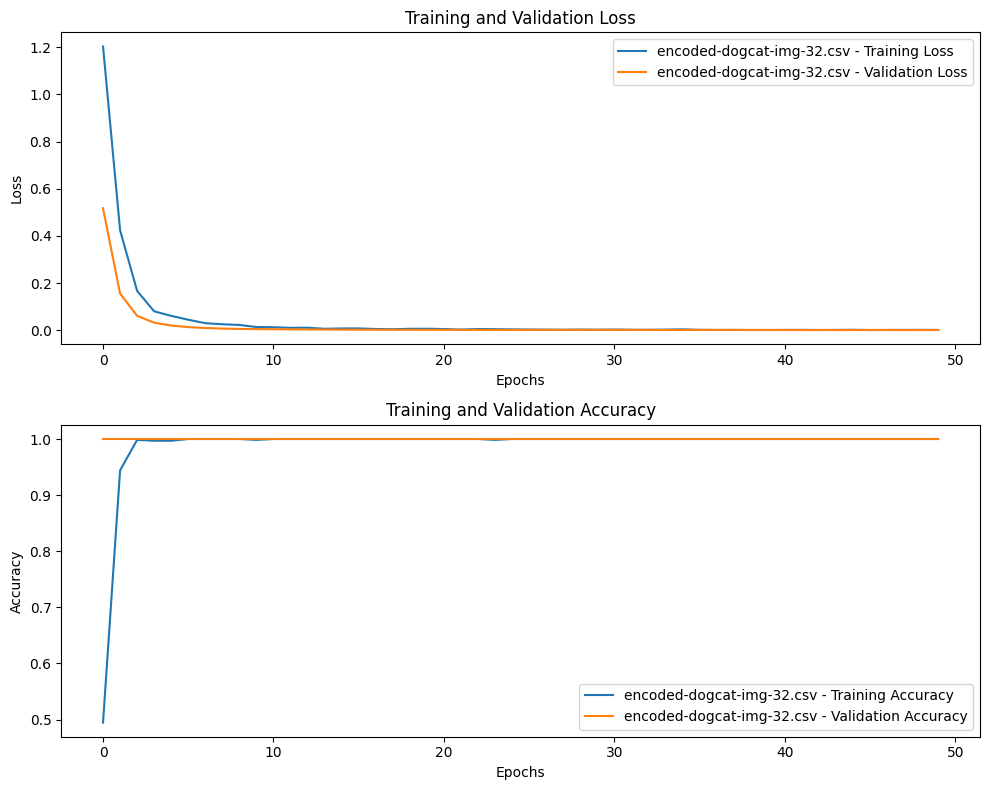

In [28]:
# Plot loss
plt.figure(figsize=(10, 8))
for i, history in enumerate(histories):
    plt.subplot(2, 1, 1)  # Dua baris, satu kolom, plot pertama
    plt.plot(history.history['loss'], label=f'{file_names[i]} - Training Loss')
    plt.plot(history.history['val_loss'], label=f'{file_names[i]} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

# Plot akurasi
for i, history in enumerate(histories):
    plt.subplot(2, 1, 2)  # Dua baris, satu kolom, plot kedua
    plt.plot(history.history['accuracy'], label=f'{file_names[i]} - Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{file_names[i]} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [29]:
res_nn_model = pd.DataFrame({
    'dataset_source': file_names,
    'accuracy' : accuracies
})

res_nn_model.head()

,dataset_source,accuracy
0,encoded-dogcat-img-32.csv,1.0
